In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")
from tensorflow import keras
from sklearn.cluster import KMeans
import random
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from Data_Prepear import data_prepear
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
tf.__version__
from xgboost import XGBRegressor

2024-10-26 16:39:09.667882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 16:39:09.671117: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-26 16:39:09.682127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 16:39:09.701635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 16:39:09.707604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 16:39:09.720305: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# read the orginal data from the csv file
df1 = pd.read_csv("well5.csv")
df1['date'] = pd.to_datetime(df1['date'], errors='coerce') #convert date column to datetime format
# df1 = df1[(df1["dp_tubing"] > 100) & (df1["bhp"] > 200) & (df1["bht"] > 80)]
# =========================================
# create a dummy date time with freq = 1D to see which days we have no data
df = pd.DataFrame({
    'date': pd.date_range(start='2014-04-21', periods=717, freq='D')
})
# =========================================
# Merge on the 'date' column, using 'left' join to keep all dates from df1
df = df.merge(df1, on='date', how='left')

df = df[[
    "date", "bhp", "bht",
    "dp_tubing", "AVG_CHOKE_SIZE_P",
    "QG"]]
df.set_index('date', inplace=True)
df['Time'] = np.arange(len(df.index))
df.dropna(inplace=True)
df.head()

,bhp,bht,dp_tubing,AVG_CHOKE_SIZE_P,QG,Time
date,,,,,,
2014-04-21,199.786581,106.658980,155.118109,12.403833,38570.590000,0
2014-04-22,199.969739,106.652065,155.260995,12.310589,34001.500000,1
2014-04-23,199.773930,106.656580,155.136833,11.740151,33067.045161,2
2014-04-24,204.997626,106.290154,158.704731,10.226906,33552.408709,3
2014-04-25,199.749247,106.622406,154.847998,12.133490,35254.330000,4


In [3]:
create_data = data_prepear(df, target_col ="QG", filter_value=15)
X_train, y_train, X_test, y_test = create_data.creator()

In [4]:
# Normalize features 
# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (32,1), units= 32, return_sequences = True))
model.add(LSTM(128, activation="relu",return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation="relu",return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="linear"))
# model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 128)        │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,217 (1.16 MB)

 Trainable params: 305,217 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_loss',          # Metric to monitor (you can change it)
    save_best_only=True,         # Only save the best model (based on the monitored metric)
    mode='min',                  # 'min' because we want to minimize validation loss
    verbose=1                    # Verbosity mode, to see saving details in console
)
t1 = datetime.datetime.now()
history = model.fit(x=X_train, y=y_train["y_step_4 QG"], epochs=1000, batch_size=30, validation_data = (X_test, y_test["y_step_4 QG"]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=25), checkpoint], verbose=1, shuffle=False)
# EarlyStopping(monitor='val_loss', patience=200), 
t2 = datetime.datetime.now()
print("Compilation Time : ", t2-t1)

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9067
Epoch 1: val_loss improved from inf to 0.74111, saving model to best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.9155 - val_loss: 0.7411
Epoch 2/1000
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8390
Epoch 2: val_loss did not improve from 0.74111
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8623 - val_loss: 0.8265
Epoch 3/1000
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7142
Epoch 3: val_loss did not improve from 0.74111
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7461 - val_loss: 0.8881
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7034
Epoch 4: val_loss did not improve from 0.74111
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7134 - val_loss: 0.7413
Epoch 5/1000
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6966
Epoch 5: val_loss did not improve from 0.74111
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7259 - val_loss: 0.8623
Epoch 6/1000
16/18 ━━

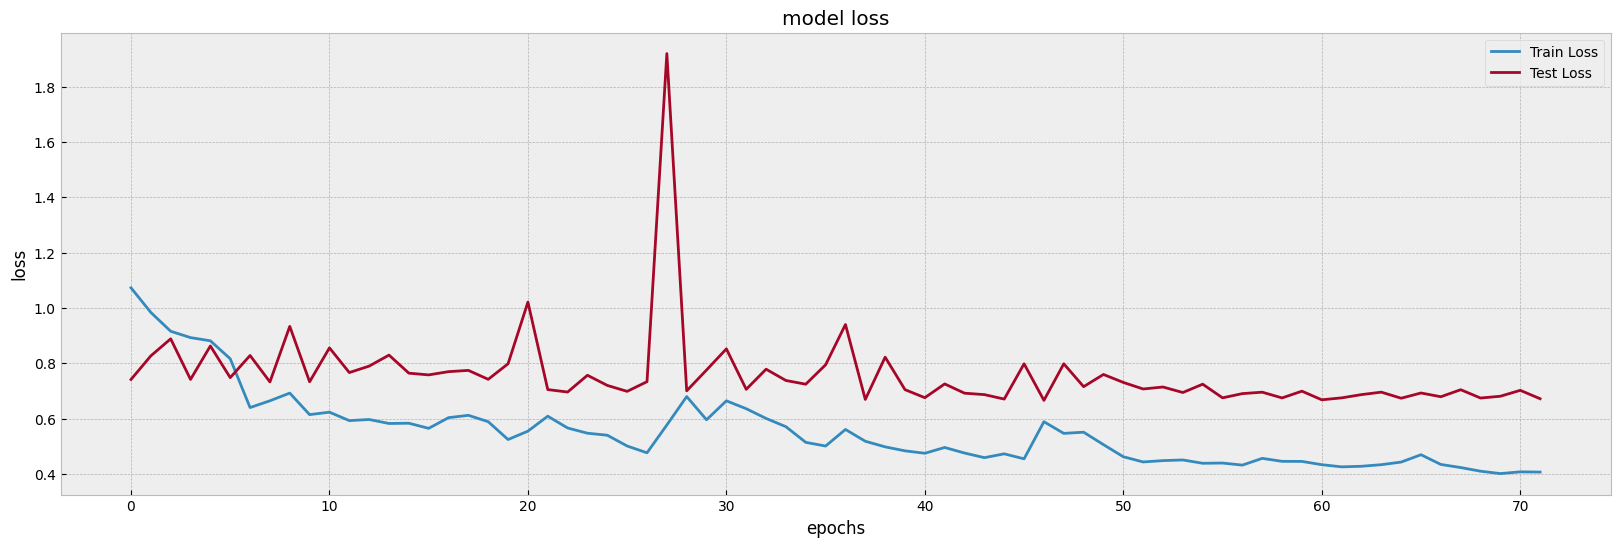

In [14]:
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [15]:
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [16]:
ss = StandardScaler()
ss.fit(df.QG.values.reshape(df.QG.shape[0],1))
true_y_train = ss.inverse_transform(y_train["y_step_4 QG"].values.reshape(y_train["y_step_4 QG"].shape[0],1))
true_y_test = ss.inverse_transform(y_test["y_step_4 QG"].values.reshape(y_test["y_step_4 QG"].shape[0],1))
true_y_fit = ss.inverse_transform(y_fit)
true_y_pred = ss.inverse_transform(y_pred)

In [17]:
train_rmse = mean_squared_error(true_y_train, true_y_fit, squared=False)
test_rmse = mean_squared_error(true_y_test , true_y_pred, squared=False)
range_train =  np.max(true_y_train) - np.min(true_y_train)
range_test = np.max(true_y_test) - np.min(true_y_test)
print("train RMSE: ",train_rmse)
print("train Range:",range_train)
print("Percent_Erorr:", (train_rmse/range_train)*100, "%")
print("test_RMSE: ", test_rmse)
print("test Range:",range_test)
print("Percent_Erorr:", (test_rmse/range_test)*100, "%")

train RMSE:  5017.214088368133
train Range: 93690.37047215656
Percent_Erorr: 5.355101130547005 %
test_RMSE:  6463.13294093977
test Range: 39940.7
Percent_Erorr: 16.1818219033211 %


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


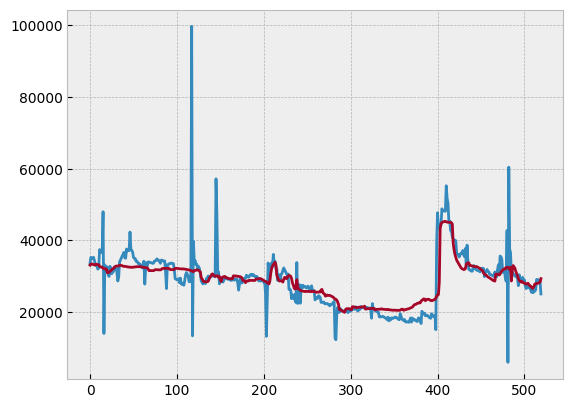

In [18]:
plt.plot(true_y_train)
plt.plot(true_y_fit)

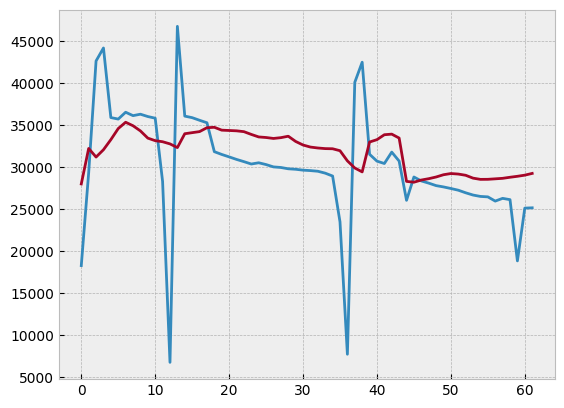

In [19]:
plt.plot(true_y_test)
plt.plot(true_y_pred)

[Text(0.5, 1.0, 'Train'), Text(0.5, 0, 'True_value'), Text(0, 0.5, 'Pridct')]

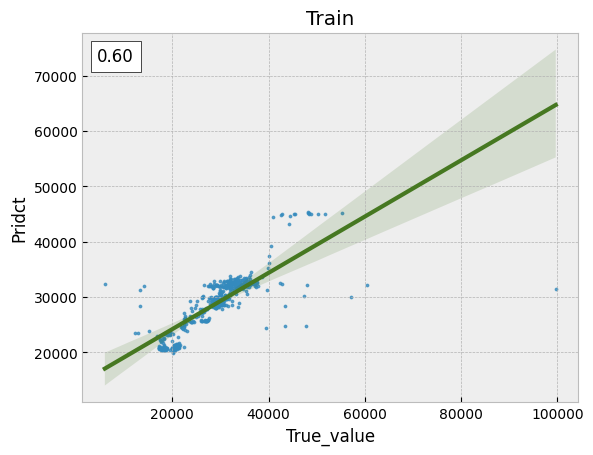

In [20]:
corr = r2_score(true_y_train, true_y_fit)
fig, ax = plt.subplots()
scatter_kws = dict(
    alpha=0.75,
    s=3,
)
line_kws = dict(color="C3")
ax = sns.regplot(
    x = true_y_train,
    y = true_y_fit,
    scatter_kws= scatter_kws,
    line_kws = line_kws,
    # lowess=True,
    ax=ax,
)
at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
at.patch.set_boxstyle("square, pad=0.0")
ax.add_artist(at)
ax.set(title="Train", xlabel="True_value", ylabel="Pridct")

[Text(0.5, 1.0, 'test'), Text(0.5, 0, 'True_value'), Text(0, 0.5, 'Pridct')]

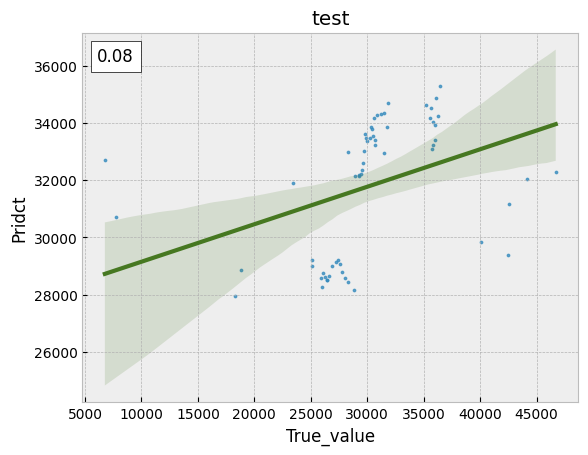

In [21]:
corr = r2_score(true_y_test, true_y_pred)
fig, ax = plt.subplots()
scatter_kws = dict(
    alpha=0.75,
    s=3,
)
line_kws = dict(color="C3")
ax = sns.regplot(
    x = true_y_test,
    y = true_y_pred,
    scatter_kws= scatter_kws,
    line_kws = line_kws,
    # lowess=True,
    ax=ax,
)
at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
at.patch.set_boxstyle("square, pad=0.0")
ax.add_artist(at)
ax.set(title="test", xlabel="True_value", ylabel="Pridct")